In [1]:
#import all the libraries
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#initialising all the global varaibles
#since all the values of the given problem are initialised here so we can change it here
#The program is not running for higher values

TOTAL_LOCATIONS = 3

MAX_CAR_LOC1 = 4
MAX_CAR_LOC2 = 4
MAX_CAR_LOC3 = 4

MAX_CAR = [4 , 4 , 4]

LAMBDA_REQ_LOC1 = 3
LAMBDA_REQ_LOC2 = 2
LAMBDA_REQ_LOC3 = 2

LAMBDA_RETURN_LOC1 = 3
LAMBDA_RETURN_LOC2 = 1
LAMBDA_RETURN_LOC3 = 1

MAX_CAR_SHIFT = 3

GAMMA = 0.9

CAR_REQUEST_REWARD = 10
CAR_MOVE_COST_LOC1_LOC2 = -2
CAR_MOVE_COST_LOC2_LOC3 = 0
CAR_MOVE_COST_LOC1_LOC3 = -2

THRESHOLD_CONVERGENCE = 0.1

P_BACKUP = {}

In [3]:
#this is for the state space
state_space = []

for x in range(MAX_CAR_LOC1 + 1):
    for y in range(MAX_CAR_LOC2 + 1):
        for z in range(MAX_CAR_LOC3 + 1):
            state_space.append((x , y , z))
            

#for the state values
state_values = np.zeros((MAX_CAR_LOC1+1 , MAX_CAR_LOC2+1 , MAX_CAR_LOC3+1))
policy = np.zeros((MAX_CAR_LOC1+1 , MAX_CAR_LOC2+1 , MAX_CAR_LOC3+1))
#action space

#action is also a four tuple:
    #first element : Gives the first location
    #second element : Gives the second location
    #third element : Number of cars to be moved from first location to third location
    #fourth element : Number of cars to be moved from second location to third location
    
action_space = []

for x in range(TOTAL_LOCATIONS):
    for y in range(x+1 , TOTAL_LOCATIONS):
        for a in range(MAX_CAR_SHIFT + 1):
            for b in range(5 - a + 1):
                action_space.append( (x , y , a , b) )
                action_space.append( (y , x , a , b) )

action_space = sorted(action_space)

#for the size of action space and the state space
print("Size of action space : " , len(action_space) )
print("Size of state space : " , len(state_space))
print("Size of state values : " , state_values.shape )

#print(action_space)

Size of action space :  108
Size of state space :  125
Size of state values :  (5, 5, 5)


In [4]:
#given the value of the x and the lambda it will give the probability of the distribution
def poisson (x , lam):
    global P_BACKUP
    key = (x , lam)
    if key not in P_BACKUP.keys():
        P_BACKUP[key] = np.exp(-lam) * pow(lam , x) / math.factorial(x)
    
    return P_BACKUP[key]

In [5]:
#given an action it will check if the given action is valid or not in that particular state


#action is also a four tuple:
    #first element : Gives the first location
    #second element : Gives the second location
    #third element : Number of cars to be moved from first location to third location
    #fourth element : Number of cars to be moved from second location to third location

def action_valid (action , state):
    
    #extract the values
    car1 , car2 , car3 = state
    loc1 , loc2 , move_13 , move_23 = action
    
    #the action will be invalid if the cars at particular location is less than it want to sent to 
    #other location
    
    if (state[loc1] < move_13):
        return False
    
    if (state[loc2] < move_23):
        return False
    
    return True
    

In [6]:
action = (2 , 0 , 2 , 3)
state = (2, 0 , 5)
print(action_valid(action , state))

False


In [7]:
#Given the state and the action it will return the new state
#Note this function do not check if the action is valid or not in that particular state
#this will also return the reward

def other_location (loc1 , loc2):
    return (3 - (loc1 + loc2))
    



def next_state (action , state):
    loc1 , loc2 , move_13 , move_23 = action
    
    #this is the third location
    loc3 = other_location(loc1 , loc2)
    
    #now move the cars from loc1 to loc3 and loc2 to loc3
    new_state = [-1 , -1 , -1]
    
    new_state[loc1] = state[loc1] - move_13
    new_state[loc2] = state[loc2] - move_23
    
    new_state[loc3] = state[loc3] + move_13 + move_23
    new_state[loc3] = min(new_state[loc3] , MAX_CAR[loc3] )

    reward = 0
    if ( (loc1 == 0 and loc3 == 1) or (loc1 == 1 and loc3 == 0)):
        reward += move_13 * CAR_MOVE_COST_LOC1_LOC2
    elif ((loc1 == 0 and loc3 == 2) or (loc1 == 2 and loc3 == 0)):
        reward += move_13 * CAR_MOVE_COST_LOC1_LOC3
    elif((loc1 == 1 and loc3 == 2) or (loc1 == 2 and loc3 == 1)):
        reward += move_13 * CAR_MOVE_COST_LOC2_LOC3
        
    if ( (loc2 == 0 and loc3 == 1) or (loc2 == 1 and loc3 == 0)):
        reward += move_23 * CAR_MOVE_COST_LOC1_LOC2
    elif ((loc2 == 0 and loc3 == 2) or (loc2 == 2 and loc3 == 0)):
        reward += move_23 * CAR_MOVE_COST_LOC1_LOC3
    elif((loc2 == 1 and loc3 == 2) or (loc2 == 2 and loc3 == 1)):
        reward += move_23 * CAR_MOVE_COST_LOC2_LOC3
    
    
    
    return (new_state[0] , new_state[1] , new_state[2] , reward)
    

In [8]:
action = (1 , 2 , 2 , 2)
state = (3, 2 , 2)

print(next_state(action , state))

(4, 0, 0, -8)


In [9]:
#given the state and the action this will give the new value of taking that action in that state
#note this function is not going to check the validity of the action
#it will just return the new value of the state given the state and the action


def new_state_value (action , state , state_values):
    
    ret = -1
    #after moving the cars what is the cost of moving and the next state n_state
    cars_loc1 , cars_loc2 , cars_loc3, ret = next_state(action , state)
    n_state = (cars_loc1 , cars_loc2, cars_loc3)
    
    #from n_state go to all the states with poisson distribution and accumulate the reward
    
    #rentals mean they will give this many car to the values
    #if request is greater than cars available then request changes to cars available
    for rentals_loc1 in range(0 , MAX_CAR_LOC1):
        for rentals_loc2 in range(0 , MAX_CAR_LOC2):
            for rentals_loc3 in range(0 , MAX_CAR_LOC3):
                rental_prob = poisson(rentals_loc1 , LAMBDA_REQ_LOC1) * poisson(rentals_loc2 , LAMBDA_REQ_LOC2) * poisson(rentals_loc3 , LAMBDA_REQ_LOC3) 
                
                total_rental_loc1 = min(cars_loc1 , rentals_loc1)
                total_rental_loc2 = min(cars_loc2 , rentals_loc2)
                total_rental_loc3 = min(cars_loc3 , rentals_loc3)
                
                rewards = (total_rental_loc1 + total_rental_loc2 + total_rental_loc3) * CAR_REQUEST_REWARD
                
                for returns_loc1 in range(0 , MAX_CAR_LOC1):
                    for returns_loc2 in range(0 , MAX_CAR_LOC2):
                        for returns_loc3 in range(0 , MAX_CAR_LOC3):
                            
                            return_prob = poisson(returns_loc1 , LAMBDA_RETURN_LOC1) * poisson(returns_loc2 , LAMBDA_RETURN_LOC2) * poisson(returns_loc3 , LAMBDA_RETURN_LOC3)
                            prob = return_prob * rental_prob
                            
                            next_state1 = min (MAX_CAR_LOC1 , cars_loc1 - total_rental_loc1 + returns_loc1)
                            next_state2 = min(MAX_CAR_LOC2 , cars_loc2 - total_rental_loc2 + returns_loc2)
                            next_state3 = min(MAX_CAR_LOC3 , cars_loc3 - total_rental_loc3 + returns_loc3)
                            
                            next_st = (next_state1 , next_state2 , next_state3)
                            ret += prob * (rewards + GAMMA * state_values[next_st])
                            
                            
    
    
    return ret

In [10]:
action = (0 , 1 , 0 , 0)
state = (4, 4 , 0)

print(new_state_value(action , state , state_values))

10.48619523664135


In [11]:
#this is synchronous update
#this will return the optimal value function

#given the old state values it will give the new state values after one complete iteration

def value_iteration(state_values , policy):
    
    #for all the states take all the actions
    threshold = -math.inf
    
    for s , state in zip(range(len(state_space)) , state_space): 
        new_value = []
        if (s % 20 == 0):
            print(s)
        for action in action_space:
            
            temp = -1
            if(action_valid(action , state)):
                temp = new_state_value(action , state , state_values)
                new_value.append(temp)
                
            else:
                new_value.append(-math.inf)
                
        optimal_value = max(new_value)
        optimal_action = np.argmax(new_value)
        
        threshold = max(threshold , abs(state_values[state] - optimal_value) )
        
        #this is updating as soon as you get answer
        state_values[state] = optimal_value
        policy[state] = optimal_action
        
    return (threshold , state_values , policy)
            

In [12]:
threshold = math.inf

num_of_iterations = 0
while (threshold > THRESHOLD_CONVERGENCE):
    num_of_iterations += 1
    threshold , state_values , policy = value_iteration(state_values , policy)
    print("Number of iterations : " , num_of_iterations , threshold)

0
20
40
60
80
100
120
Number of iterations :  1 19.398188384295295
0
20
40
60
80
100
120
Number of iterations :  2 3.728045171768395
0
20
40
60
80
100
120
Number of iterations :  3 0.6573441337898931
0
20
40
60
80
100
120
Number of iterations :  4 0.11184879729217778
0
20
40
60
80
100
120
Number of iterations :  5 0.016326754980606317


In [13]:
print(state_values)

[[[ 3.22822772  5.80728141  8.38359077 10.1699145  11.93242109]
  [ 5.8073446   8.38365885 10.16998824 11.93250089 12.85055981]
  [ 8.38373635 10.170043   11.93256132 12.85062601 13.71081492]
  [10.17009647 11.93260663 12.85067705 13.71086626 14.46879901]
  [11.9326387  12.85071883 13.71090846 14.4688358  14.70128762]]

 [[ 5.98776373  8.56674017 11.14296922 12.92895642 14.69122278]
  [ 8.56690264 11.14312573 12.92912209 14.69140076 15.60907521]
  [11.14329696 12.92924827 14.69152913 15.60921046 16.46917211]
  [12.92935119 14.69162339 15.60931425 16.46927702 16.70158979]
  [14.69168791 15.60939793 16.46936154 16.70173869 16.86751596]]

 [[ 8.12597758 10.70440493 13.28013085 15.06486686 16.82619495]
  [10.7045505  13.28026438 15.06500586 16.82634311 17.74285121]
  [13.28040579 15.06511751 16.82644506 17.742954   18.6021033 ]
  [15.0651975  16.82651846 17.74302614 18.60218379 18.83371378]
  [16.82656742 17.74308703 18.60224728 18.83381102 18.99889485]]

 [[ 9.30274079 11.8800471  14.4547

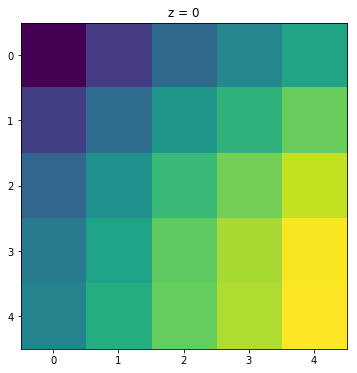

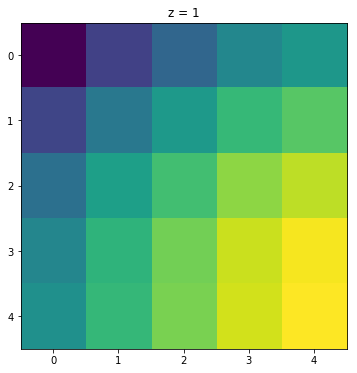

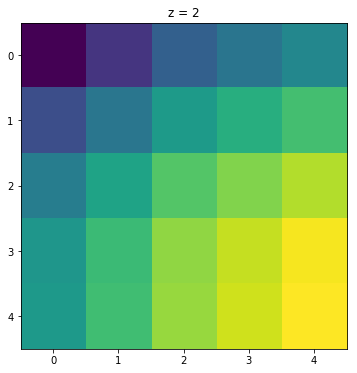

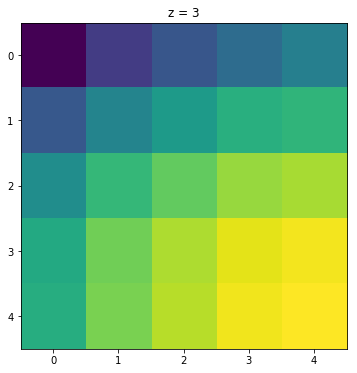

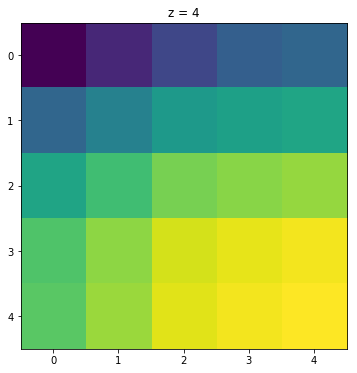

In [18]:
for i in range(state_values.shape[2]):
    plt.figure(figsize = (8 , 6))
    plt.imshow (state_values[: , : , i] , interpolation="nearest")
    plt.title("z = " + str(i))

In [15]:
print(policy)

[[[ 0. 19. 19. 20. 20.]
  [ 0.  0. 19. 19. 20.]
  [ 1.  0.  0. 19. 19.]
  [ 1.  1.  0.  0. 55.]
  [ 2.  1.  1. 60. 55.]]

 [[ 0. 19. 19. 20. 20.]
  [ 1.  0. 19. 19. 19.]
  [ 1.  1.  0. 19. 19.]
  [ 1.  1.  0.  0. 19.]
  [ 2.  1.  1.  0.  0.]]

 [[ 0. 19. 19. 20. 20.]
  [ 1.  0. 19. 19. 19.]
  [ 1.  1.  0.  0. 19.]
  [ 2.  1.  1.  0.  0.]
  [ 2.  1.  1.  0.  0.]]

 [[ 0. 19. 19. 20. 20.]
  [ 1.  0. 19. 19. 20.]
  [ 1.  0.  0. 19. 19.]
  [ 1.  1.  0.  0. 19.]
  [ 2.  1.  1.  0.  0.]]

 [[24. 24. 19. 20. 20.]
  [ 6.  0. 19. 19. 19.]
  [ 1.  1.  0.  0. 19.]
  [ 2.  1.  1.  0.  0.]
  [ 2.  2.  1.  0.  0.]]]


In [16]:
print("Mapping of action encoded in policy to actual state")
for x , action in zip(range(1 , len(action_space) + 1) , action_space):
    print(x , action)

Mapping of action encoded in policy to actual state
1 (0, 1, 0, 0)
2 (0, 1, 0, 1)
3 (0, 1, 0, 2)
4 (0, 1, 0, 3)
5 (0, 1, 0, 4)
6 (0, 1, 0, 5)
7 (0, 1, 1, 0)
8 (0, 1, 1, 1)
9 (0, 1, 1, 2)
10 (0, 1, 1, 3)
11 (0, 1, 1, 4)
12 (0, 1, 2, 0)
13 (0, 1, 2, 1)
14 (0, 1, 2, 2)
15 (0, 1, 2, 3)
16 (0, 1, 3, 0)
17 (0, 1, 3, 1)
18 (0, 1, 3, 2)
19 (0, 2, 0, 0)
20 (0, 2, 0, 1)
21 (0, 2, 0, 2)
22 (0, 2, 0, 3)
23 (0, 2, 0, 4)
24 (0, 2, 0, 5)
25 (0, 2, 1, 0)
26 (0, 2, 1, 1)
27 (0, 2, 1, 2)
28 (0, 2, 1, 3)
29 (0, 2, 1, 4)
30 (0, 2, 2, 0)
31 (0, 2, 2, 1)
32 (0, 2, 2, 2)
33 (0, 2, 2, 3)
34 (0, 2, 3, 0)
35 (0, 2, 3, 1)
36 (0, 2, 3, 2)
37 (1, 0, 0, 0)
38 (1, 0, 0, 1)
39 (1, 0, 0, 2)
40 (1, 0, 0, 3)
41 (1, 0, 0, 4)
42 (1, 0, 0, 5)
43 (1, 0, 1, 0)
44 (1, 0, 1, 1)
45 (1, 0, 1, 2)
46 (1, 0, 1, 3)
47 (1, 0, 1, 4)
48 (1, 0, 2, 0)
49 (1, 0, 2, 1)
50 (1, 0, 2, 2)
51 (1, 0, 2, 3)
52 (1, 0, 3, 0)
53 (1, 0, 3, 1)
54 (1, 0, 3, 2)
55 (1, 2, 0, 0)
56 (1, 2, 0, 1)
57 (1, 2, 0, 2)
58 (1, 2, 0, 3)
59 (1, 2, 0, 4)
60 (1, 2, 0, 